# Univariate Statistical Inference

After receiving data and completing some initial data exploration, we typically move on to performing some univariate estimation and prediction tasks. A widespread tool for performing estimation and prediction is statistical inference. Statistical inference is the process of deducing properties about a population where the population is assumed to be larger than the observed data set you are currently working with. In other words, statistical inference helps you estimate parameters of a larger population when the observed data you are working with is a subset of that population. In this tutorial we examine univariate methods for statistical estimation and prediction that can provide you more confidence of your estimates when working with sample data.

### Replication

In this tutorial we’ll illustrate the key ideas using Ames, IA home sales data and employee attrition data; both provided by R packages. To illustrate the key concepts, we assume that our two data sets (ames_pop and attr_pop) represent full population data and we create samples from these populations to perform inference on.

In [15]:
# packages used regularly
library(dplyr)
library(ggplot2)

# full population data
ames_pop <- AmesHousing::make_ames()
attr_pop <- rsample::attrition

# reproducibility
set.seed(123)

# creating samples
ames_sample <- sample_frac(ames_pop, .5)
attr_sample <- sample_frac(attr_pop, .5)

### Confidence intervals of the mean

A confidence interval estimate of a population parameter consists of an interval of numbers produced by a point estimate and an associated confidence level specifying the probability that the interval contains the parameter. Most confidence intervals take the general form

point estimate ± margin of error

where the margin of error is a measure of the precision of the interval estimate. Smaller margin of errors indicate greater precision. Why is it important to incorporate this margin of error when working with a sample? As you can see, the mean sale price for the entire ames data set (the population) is 180,796.

In [16]:
round(mean(ames_pop$Sale_Price),2)

[1] 180796.1

In [17]:
round(mean(ames_sample$Sale_Price),2)

[1] 180873

If we were to grab a different sample of 50% of the population, our mean changes.

In [18]:
# reproducibility
set.seed(120)

# creating samples
ames_sample <- sample_frac(ames_pop, .5)
round(mean(ames_sample$Sale_Price),0)

[1] 179101

In fact, if we were able to repeat this process 1000 times, each time our sample mean would be slightly different; however, we would create a normal distribution around the estimated population mean; in this example the mean of our 1000 sample means is 180,831 with 95% confidence of being between 177,772 and 183,888. Compare this to the true population mean of 180,796.

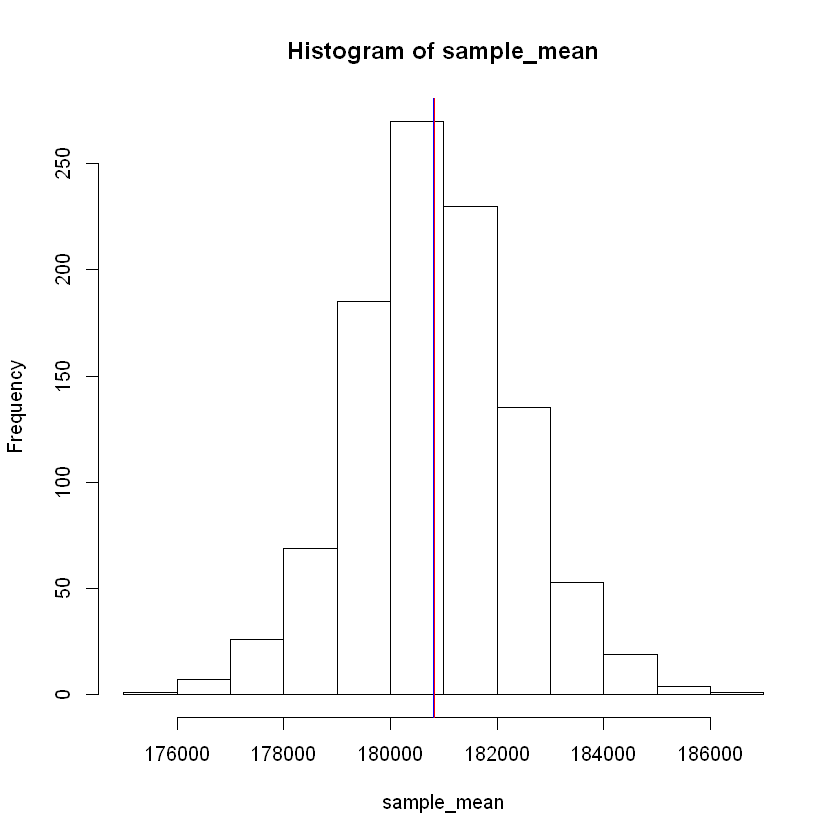

In [22]:
sample_mean <- vector(mode = "double", length = 1000)

# creating 1000 sample means
for(i in seq_along(sample_mean)) {
  set.seed(i)
  sample <- sample_frac(ames_pop, .5)
  mean_stat <- mean(sample$Sale_Price)
  sample_mean[i] <- mean_stat
}

hist(sample_mean)
abline(v = mean(sample_mean), col = "red")          # average of 1000 sample means
abline(v = mean(ames_pop$Sale_Price), col = "blue") # true population mean



Unfortunately, when working with samples we typically do not have the population data to compare to so we need to estimate a confidence interval for our population mean by only using information from our sample. To compute a confidence interval we can use the t-interval, which produces reliable confidence intervals so long as our population is from a normal distribution or the sample size is large. Equation 1 represents our t-interval

In [24]:
# original ames sample data
set.seed(123)
ames_sample <- sample_frac(ames_pop, .5)

# compute equation parameters
x <- ames_sample$Sale_Price
xbar <- mean(x)                        # mean 
multi <- qt(.975, df = length(x) - 1)  # multiplier
sigma <- sd(x)                         # standard deviation
denom <- sqrt(length(x))               # square root of n

# compute standard error
se <- multi * (sigma / denom)

# lower and upper confidence boundary
round(xbar + c(-se, se),2)

[1] 176802.0 184944.1

Based on our sample data we can be 95% confident that the true population mean sales price is between $176,802 and $184,944. In our case, we know the true population mean is $180,796, which is appropriately captured by our 95% confidence interval. Consequently, when we only have sample data of a larger population we can adequately estimate the range that the true population parameter falls in with confidence intervals.

Unfortunately, R does not have a built-in function to compute mean confidence intervals. We could develop a function for this or we can just use the built-in t.test function, which provides confidence intervals along with other information we’ll cover shortly.

In [25]:
t.test(ames_sample$Sale_Price)


	One Sample t-test

data:  ames_sample$Sale_Price
t = 87.151, df = 1464, p-value < 2.2e-16
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 176802.0 184944.1
sample estimates:
mean of x 
   180873 


### Reducing margin of error

we can decrease the margin of error in two ways:


By decreasing the confidence level, which reduces the value of tα/2 and therefore reduces the overal margin of error. However, this is not recommended as it reduces the margin of error by reducing our confidence in the overall confidence interval.

By increasing the sample size.

Increasing the sample size is the only way to decrease the margin of error while maintaining a constant level of confidence. In essence, increasing the sample size just means you are collecting more observations from the overall population and as you add more observations, your sample mean will be a better representation of the population mean. We can illustrate this by sampling from 2,3,…,n

observations from the ames population and computing the sample mean. As the below figure demonstrates, as the sample size approaches the population size the mean values converge with the true population mean.

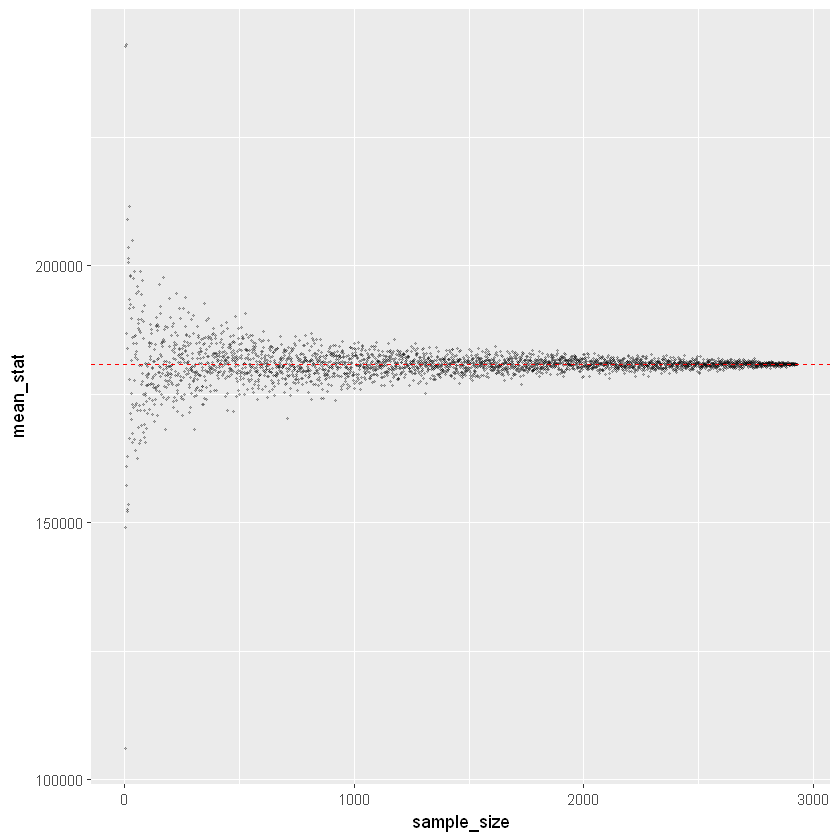

In [26]:
sample_size <- 2:nrow(ames_pop)

results <- tibble(
  sample_size = sample_size, 
  mean_stat = 0
  )

for(i in seq_along(sample_size)) {
  sample <- sample_n(ames_pop, sample_size[i])
  mean_stat <- mean(sample$Sale_Price)
  results[i, 2] <- mean_stat
}

ggplot(results, aes(sample_size, mean_stat)) +
  geom_point(alpha = .25, size = .5) +
  geom_hline(yintercept = mean(ames_pop$Sale_Price), color = "red", lty = "dashed")

## Confidence intervals of the proportion

We can also produce confidence intervals for categorical variables. The simplest approach is to perform inference on the population proportion (π). Consider the churn rate of our sample attrition data. The sample shows that 16% of sampled employees had churned (aka attrition).

In [27]:
attr_sample%>%
    count(Attrition)%>%
    mutate(pct=n/sum(n))

Attrition,n,pct
No,614,0.8353741
Yes,121,0.1646259


Unfortunately, with respect to the population of our entire employee base, we have no measure of confidence in how well this sample estimate aligns with the population churn rate. In fact, it is nearly impossible that this value exactly equals π . Thus, we would prefer a confidence interval for the population proportion, which can be computed with the Z-interval:

p±Zα/2√p⋅(1−p)

where the sample proportion p is the point estimate of π and the quantity Zα/2√p⋅(1−p)n represents the margin of error. Zα/2 is the z value providing an area of α/2 in the upper tail of the standard normal distribution. Typical values include:


90% confidence: Zα/2=1.645

95% confidence: Zα/2=1.96

99% confidence: Zα/2=2.576

This Z-interval for π may be used whenever both n×p≥5 and n(1−p)≥5. For example, a 95% confidence interval for the proportion of churners in the entire employee population is given by:


In [28]:
attr_sample %>%
  count(Attrition) %>%
  mutate(
    pct      = n / sum(n),
    lower.95 = pct - qnorm(.975) * sqrt((pct * (1 - pct)) / sum(n)),
    upper.95 = pct + qnorm(.975) * sqrt((pct * (1 - pct)) / sum(n))
    )

Attrition,n,pct,lower.95,upper.95
No,614,0.8353741,0.8085643,0.8621840
Yes,121,0.1646259,0.1378160,0.1914357


Now we can state that we are 95% confidence that the population attrition rate is between 13.8-19%. In fact, when we assess the population proportion in the attrition data we find that π=16%, which falls right in the middle of our estimated confidence interval.

attr_pop %>%
  count(Attrition) %>%
  mutate(pct = n / sum(n))

# Hypothesis testing for the mean

Hypothesis testing is a procedure where claims about the value of a population parameter (such as μ or π

) may be considered using the evidence from the sample. Two competing statements, or hypotheses, are crafted about the parameter value:

The null hypothesis H0 is the status quo hypothesis, representing what has been assumed about the value of the parameter.

The alternative hypothesis represents the alternative claim about the value of the parameter.

Traditionally, the two possible conclusions of hypothesis testing have been (i) reject H0 or (ii) do not reject H0 based on the p-value (typically p≤0.05). For example, a criminal trial is a form of a hypothesis test where
H0:Defendant is innocentHa:Defendant is guilty

As the below table illustrates, there are four possible outcomes of a criminal trial with respect to the jury’s decision, and what is true in reality.

Correct decisions:
        Do not reject H0 if there is not enough evidence against the defendant. The jury acquits an innocent person.

Reject H0 if there is sufficient evidence against the defendant. The jury convicts a guilty person.

Erroneous decisions:

Type I error: Reject H0 when H0 is true. The jury convicts an innocent person.

Type II error: Do not reject H0 when H0 is false. The jury acquits a guilter person.

The probability of a Type I error is denoted as α, while the probability of a Type II error is denoted as β. For a constant sample size, a decrease in α is associated with an increase in β, and vice versa. In statistical inference, α is usually fixed at some small value, such as 0.05, and called the level of signficance.

A common treatment of hypothesis testing for the mean is to restrict the hypotheses to the following three forms:

Left-tailed test. H0:μ≥μ0  versus Ha:μ<μ0

Right-tailed test. H0:μ≤μ0 versus Ha:μ>μ0

Two-tailed test. H0:μ=μ0 versus Ha:μ≠μ0

where μ0 represents a hypothesized value of μ.

When the sample size is large or the population is normally distributed, we can use t (Equation 3) as a test statistic to determine whether x deviates from the hypothesized value enough to justify rejecting the null hypothesis.

t=x−μ0/s/√n

The value of t is interpreted as the number of standard errors above or below the hypothesized mean μ, that the sample mean ¯x resides, where the standard error equals s√n. When t is large, it provides supporting evidence against the null hypothesis H0. How do we determing if we have enough supporting evidence to reject H0

? This is measured by the p-value.

The p-value is the probability of observing a sample statistic (such as ¯x
) at least as extreme as the statistic actually observed, if we assume H0 is true. Thus, a p-value of 0.05 suggests there is only a 5% probability of observing ¯x if the population value is actually μ0 as H0 suggests. Consequently, the smaller the p-value, the smaller the probability that ¯x aligns with the null hypothesis H0. So how small does the p-value need to be to reject H0 ?

Historically, p-value≤0.05
has been the cutoff commonly used to reject H0. However, it is becoming more common for data analysts to not think in terms of whether or not to reject H0 so much as to assess the strength of evidence against the null hypothesis.

## Application of t-test

To perform a t-test in R we use the t.test function. For example, if we believe the average square footage of all homes sold in Ames, IA is 1,600 square feet then our hypothesis test would state:

H0 : μ=1600

Ha : μ≠1600

We can test this with t.test, which shows that t=−8.5491
, which is sufficiently large. In fact, it is so large that the p-value states there is less than 2.2×10−16 probability of ¯x=1492.856 if the population mean was 1600. This provides extremely strong evidence against H0. The results also tell us that the 95% confidence interval for the population mean μ0, suggesting that the μ0 likely falls between 1468-1517 square feet.

In [33]:
t.test(ames_sample$Gr_Liv_Area, mu=1600)


	One Sample t-test

data:  ames_sample$Gr_Liv_Area
t = -8.5491, df = 1464, p-value < 0.00000000000000022
alternative hypothesis: true mean is not equal to 1600
95 percent confidence interval:
 1468.272 1517.440
sample estimates:
mean of x 
 1492.856 


We can also perform right and left-tailed tests by including the alternative argument. For example, if you owned a home in Ames, IA that had 1200 square feet on the first floor and you wanted to test if your home’s first floor square footage was larger than the average Ames home, you use alternative = "greater"2 to test, which suggests there is extremely strong evidence that your home’s first floor is larger than the average Ames, IA home’s first floor.

H0 : μ≤1200

Ha : μ>1200

In [32]:
t.test(ames_sample$First_Flr_SF, mu=1200, alternative="less")
options(scipen=999)


	One Sample t-test

data:  ames_sample$First_Flr_SF
t = -5.1802, df = 1464, p-value = 0.0000001263
alternative hypothesis: true mean is less than 1200
95 percent confidence interval:
     -Inf 1165.977
sample estimates:
mean of x 
 1150.133 


In [34]:
t.test(ames_sample$First_Flr_SF, mu=1200, alternative="greater")


	One Sample t-test

data:  ames_sample$First_Flr_SF
t = -5.1802, df = 1464, p-value = 1
alternative hypothesis: true mean is greater than 1200
95 percent confidence interval:
 1134.289      Inf
sample estimates:
mean of x 
 1150.133 


## Hypothesis testing for the proportion

Hypothesis tests may also be performed for population proportions (π

). The test statistic is

z=p−π0√/(π0(1−π)/n)(4)

where π0 is the hypothesized value of π , and p is the sample proportion p=number of successes/n

The same logic applies for the z test statistic as the t test statistic. A sufficiently large z value provides evidence against the null hypothesis H0 ; and this strength of evidence can be measured by the p-value, which can be interpreted the same as discussed in the previous section.

We can apply the prop.test function in R for hypothesis testing of proportions. For example, we can use our attr_sample data to answer the question do males and females represent and equal proportion of those employees that attrit? In this example the hypothesis is:

H0 : πf=0.5

Ha : πf≠0.5

where the null is just testing if the proportion of females πf
equals 50%. If this hypothesis holds then men and women are approximately equally represented. We see that in our example females represent 42% of those employees who churn. We see that our prop.test results suggest that there is extremely strong evidence that females represent less than 50% of the attrition population (its estimated that they represent 38-45% based on the 95% confidence interval). In fact, females represent 40% of the population (attr_pop) data.

In [35]:
# proportions table
table(attr_sample$Gender) %>%prop.table()
    


   Female      Male 
0.4176871 0.5823129 

In [37]:
# hypothesis tests for proportions
table(attr_sample$Gender) %>% 
  prop.test()


	1-sample proportions test with continuity correction

data:  ., null probability 0.5
X-squared = 19.592, df = 1, p-value = 0.000009588
alternative hypothesis: true p is not equal to 0.5
95 percent confidence interval:
 0.3818827 0.4543636
sample estimates:
        p 
0.4176871 


It is important to note that prop.test will use the first proportion in the output of table to compute the z-test. Consequently, if you assumed that males represent more than 50% of those that churn you just need to reverse the table order.

In [39]:
table(attr_sample$Gender) %>%
  rev() %>%
  prop.test(alternative = "greater")


	1-sample proportions test with continuity correction

data:  ., null probability 0.5
X-squared = 19.592, df = 1, p-value = 0.000004794
alternative hypothesis: true p is greater than 0.5
95 percent confidence interval:
 0.5514581 1.0000000
sample estimates:
        p 
0.5823129 
